In [ ]:
## Acknowledgements

# This project uses the following libraries:
# - SDV (https://github.com/sdv-dev/SDV) by DataCebo, Inc — licensed under MIT License.
# - DataSynthesizer (https://github.com/DataResponsibly/DataSynthesizer) by dataresponsible.com - licensed under MIT license.

## To install the libraries
# pip install DataSynthesizer
# pip install SDV

## Pre-processing
Loading the dataset and finding and replacing any null values

In [ ]:
# Load libraries
import pandas as pd
import numpy as np

# Load datset
df = pd.read_csv("../data/adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
# Find and replace null values
df[df == '?'] = np.nan
print(df.isnull().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [6]:
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


/var/folders/5r/szjg0t916q322rv9b39nw33r0000gn/T/ipykernel_72291/1731946726.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


## Data Visualisation
Boxplots and histograms of the initial dataset

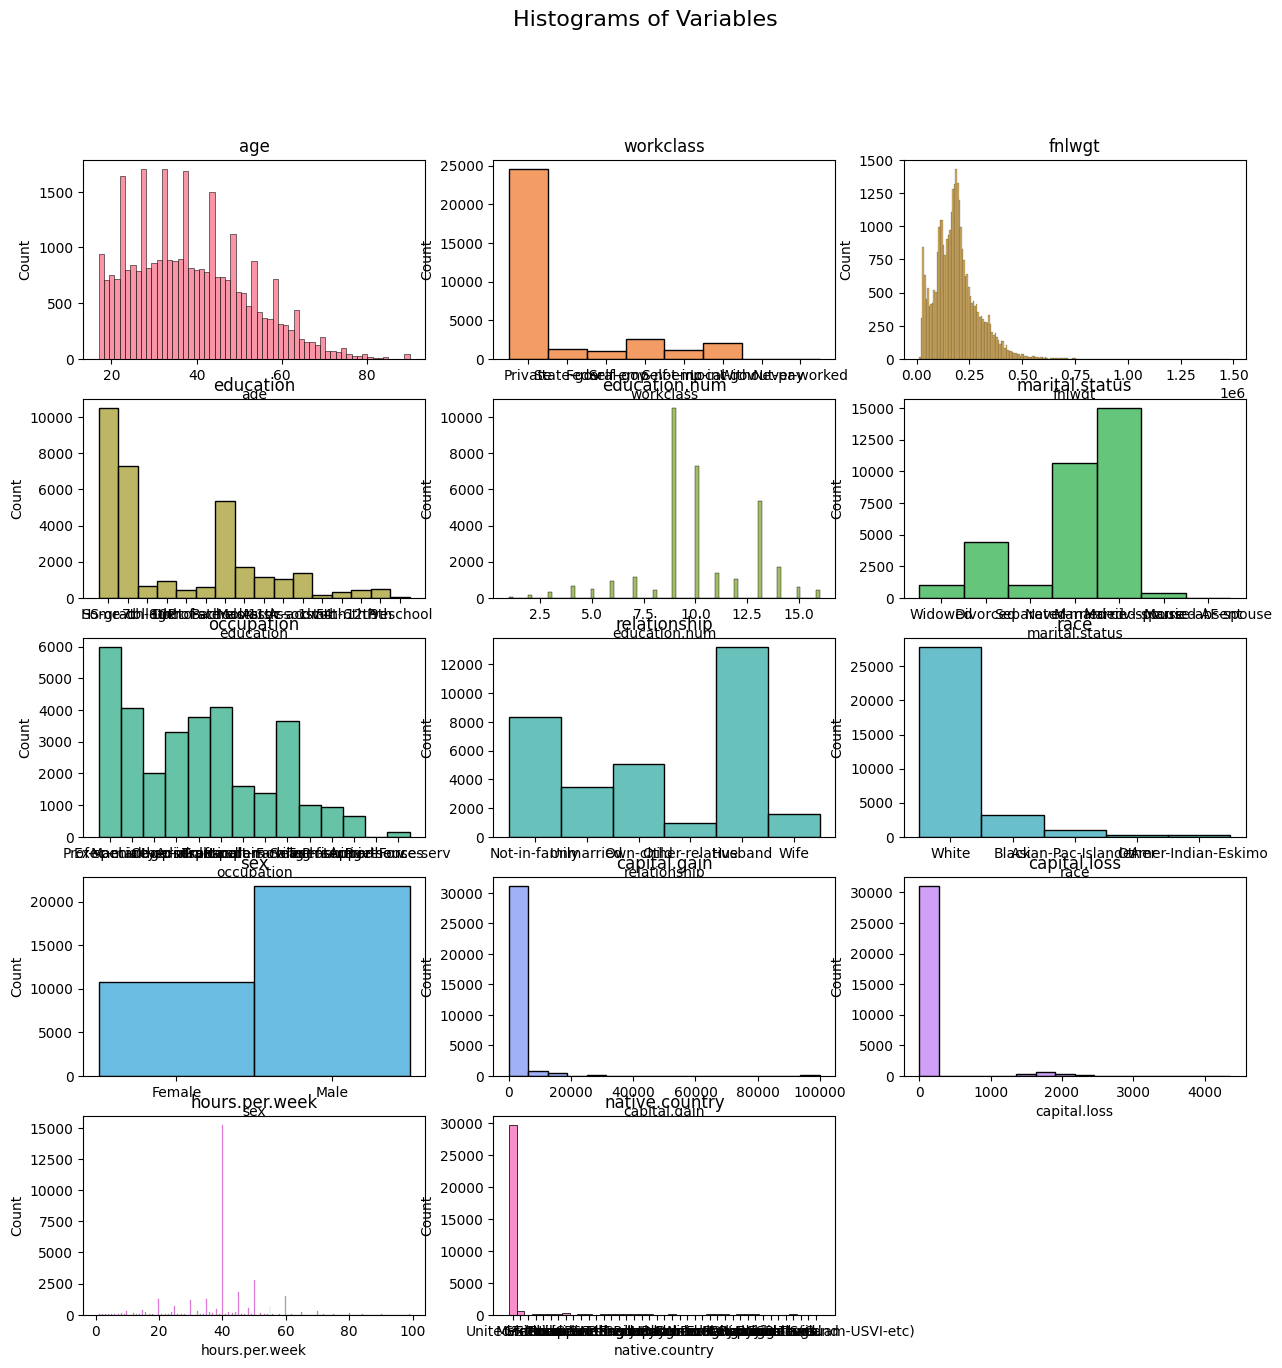

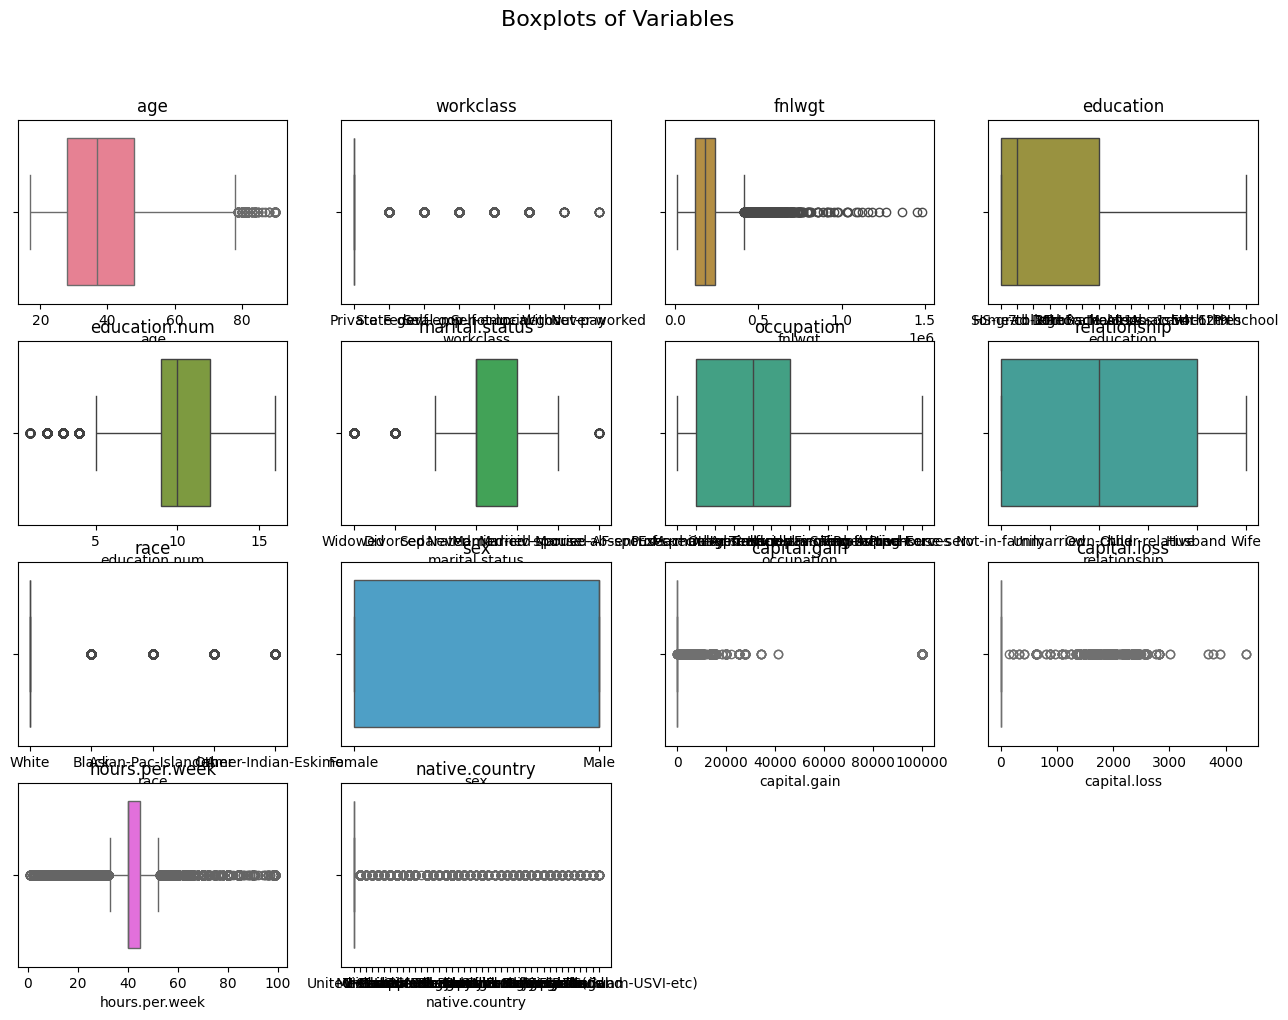

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Automatically get explanatory columns (assuming 'income' is the target)
explanatory_columns= df.columns.drop('income')

# Generate a color palette to match the number of columns
num_cols = len(explanatory_columns)
colors = sns.color_palette("husl", num_cols)

# Use 3 subplots per row
cols = 3
rows = math.ceil(num_cols / cols)


# a) Histograms
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3))

for i in range(rows):
    for j in range(cols):
        idx = i * 3 + j
        if idx < num_cols:
            sns.histplot(
                data=df,
                x=explanatory_columns[idx],
                kde=False,
                ax=axs[i, j],
                color=colors[idx]
            )
            axs[i, j].set_title(explanatory_columns[idx])
        else:
            axs[i, j].set_visible(False)

plt.suptitle("Histograms of Variables", fontsize=16)
plt.show()

# b) Boxplots
fig, axs = plt.subplots(4, 4, figsize=(16, 11))

for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        if idx < num_cols:
            sns.boxplot(
                data=df,
                x=explanatory_columns[idx],
                ax=axs[i, j],
                color=colors[idx]
            )
            axs[i, j].set_title(explanatory_columns[idx])
        else:
            axs[i, j].set_visible(False)


plt.suptitle("Boxplots of Variables", fontsize=16)
plt.show()

## Synthetic Data Generation
Implement synthetic data generation and evaluate its quality

### Metadata Generation
Create metadata. This is required by the SDV library to generate data

In [8]:
### Create metadata - important for the synthesizers
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(data=df)
metadata.validate()

### Evaluate Synthesizers
Look at the different synthesizers and evaluate quality/
- GaussianCopula - uses classic, statistical methods to train a model and generate synthetic data.
- CTGAN - GAN-based, deep learning methods to train a model and generate synthetic data.
- TVAE - uses a variational autoencoder (VAE)-based, neural network techniques to train a model and generate synthetic data.

In [ ]:
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer
from sdv.evaluation.single_table import evaluate_quality


# Define a dictionary to hold results
results = {}

# List of synthesizers to evaluate
synthesizers = {
    'GaussianCopula': GaussianCopulaSynthesizer(metadata),
    'CTGAN': CTGANSynthesizer(metadata),
    'TVAE': TVAESynthesizer(metadata)
}

# Loop through each synthesizer
for name, synthesizer in synthesizers.items():
    print(f"\nTraining and generating with {name}...")
    
    # Fit the synthesizer
    synthesizer.fit(df)
    
    # Generate synthetic data
    synthetic_data = synthesizer.sample(num_rows=len(df))
    
    # Evaluate quality
    quality_report = evaluate_quality(df, synthetic_data, metadata)
    
    # Save the results
    results[name] = quality_report

# Display quality scores
for name, report in results.items():
    print(f"\n{name} Quality Score: {report.get_score():.4f}")



Training and generating with GaussianCopula...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 137.12it/s]|
Column Shapes Score: 87.63%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:00<00:00, 168.30it/s]|
Column Pair Trends Score: 81.22%

Overall Score (Average): 84.42%


Training and generating with CTGAN...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 90.27it/s]|
Column Shapes Score: 85.94%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:00<00:00, 109.99it/s]|
Column Pair Trends Score: 84.72%

Overall Score (Average): 85.33%


Training and generating with TVAE...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 91.25it/s]|
Column Shapes Score: 90.92%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:01<00:00, 83.60it/s]|
Column Pair Trends Score: 88.18%

Overall Score (Average): 89.55%


GaussianCopula Quality Score: 0

### Data and Evaluation 
Gaussian Copula is chosen for this experiment due to its modifiability and speed.

In [10]:
# Using the Gaussian Copula Synthesizer, since it takes shorter and just for testing
# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(df)

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=len(df))

In [11]:
#### Evaluating validity of the data
# Running a diagnostic to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:
# - All primary keys must be unique
# - Continuous values must adhere to the min/max of the real data
# - Discrete columns (non-PII) must have the same categories as the real data
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 15/15 [00:00<00:00, 389.34it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 1058.37it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [12]:
synthetic_data.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,50,Self-emp-not-inc,71334,HS-grad,12,Never-married,Prof-specialty,Husband,White,Male,41262,124,33,United-States,>50K
1,36,Private,56011,Some-college,7,Married-civ-spouse,Sales,Unmarried,White,Male,75748,452,33,United-States,<=50K
2,32,Private,105622,10th,12,Never-married,Sales,Own-child,White,Female,27,3,38,United-States,<=50K
3,42,Private,253428,HS-grad,11,Never-married,Craft-repair,Husband,White,Male,6830,0,37,United-States,<=50K
4,37,Private,254280,1st-4th,13,Divorced,Prof-specialty,Husband,White,Female,61249,0,37,United-States,<=50K
5,29,State-gov,347689,HS-grad,10,Married-civ-spouse,Craft-repair,Husband,White,Male,1688,0,53,United-States,<=50K
6,60,Private,77693,Bachelors,8,Never-married,Prof-specialty,Husband,White,Female,26354,94,27,United-States,<=50K
7,46,Private,92018,Some-college,8,Married-civ-spouse,Craft-repair,Own-child,White,Female,75268,0,13,United-States,<=50K
8,42,Self-emp-not-inc,98871,HS-grad,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,54566,0,39,United-States,<=50K
9,23,Private,438317,Bachelors,10,Never-married,Machine-op-inspct,Not-in-family,White,Female,8992,1,45,United-States,<=50K


### Statistical Similarity
Ensuring the dataset reflects the same patterns as the original

Histograms
To show distribution differences between the real and synthetic data.

In [23]:
############### Histogram differences #########################
from DataSynthesizer.lib.utils import read_json_file
from DataSynthesizer.ModelInspector import ModelInspector

## Using Inspector from DataSynthesizer
attribute_description = read_json_file("out/description.json")['attribute_description']

inspector = ModelInspector(df, synthetic_data, attribute_description)

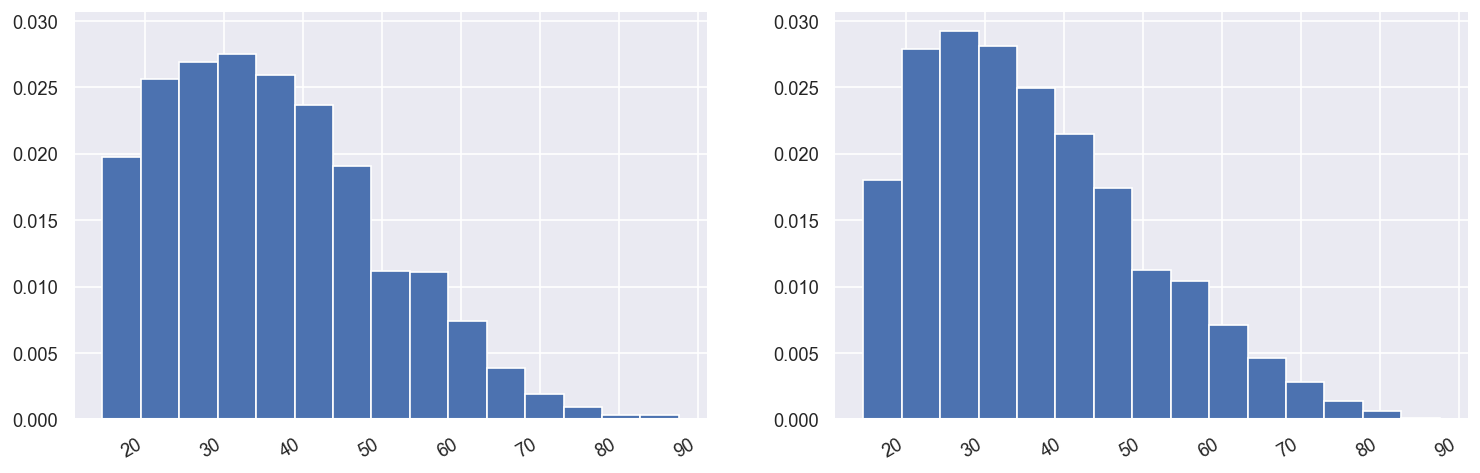

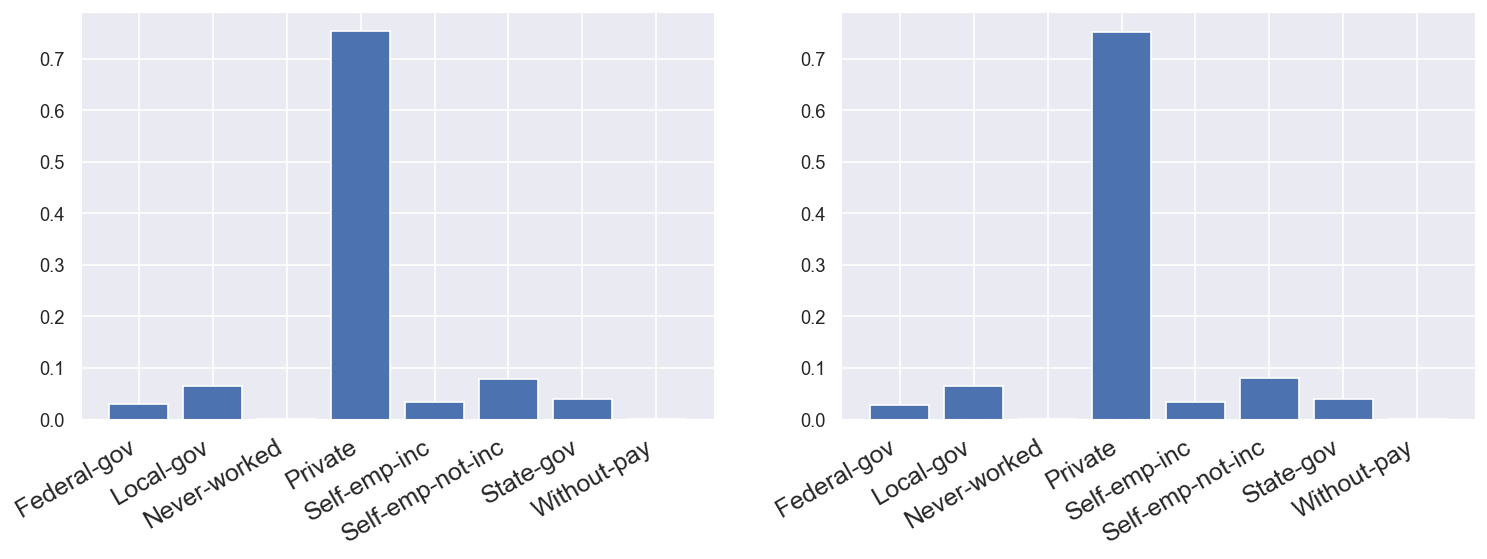

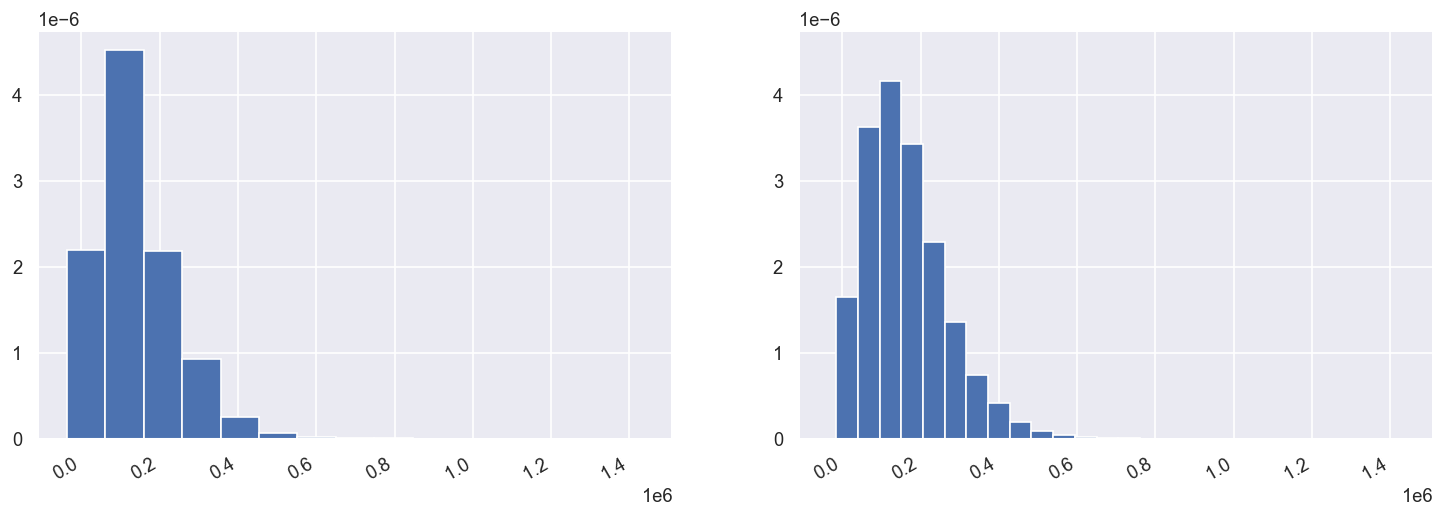

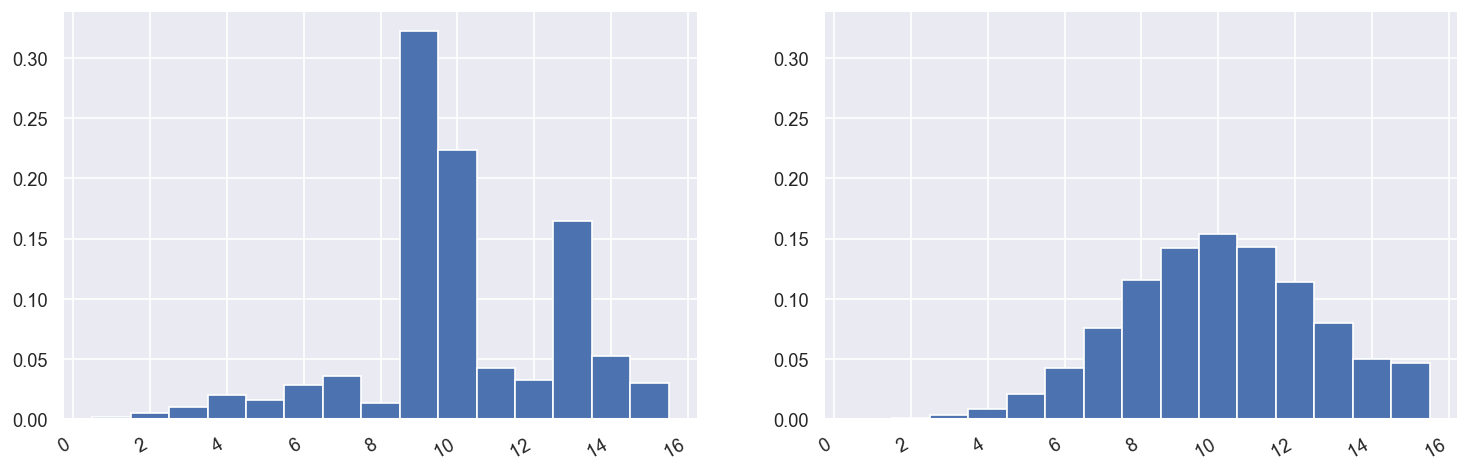

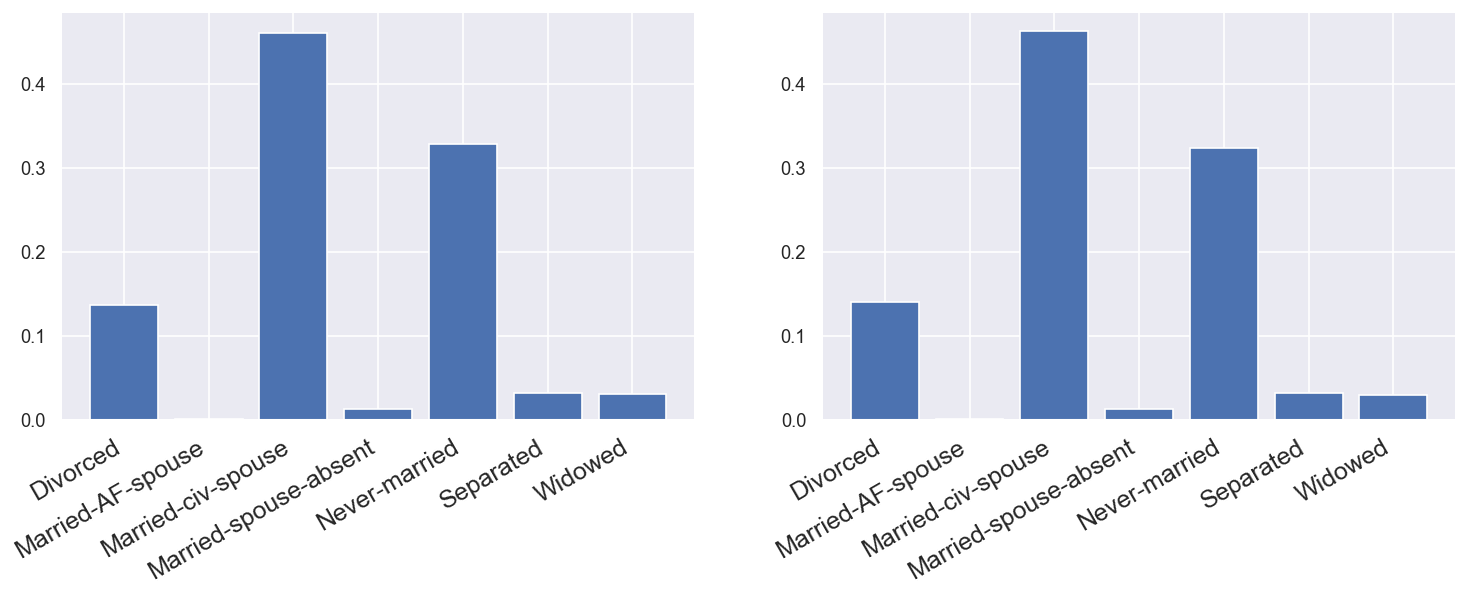

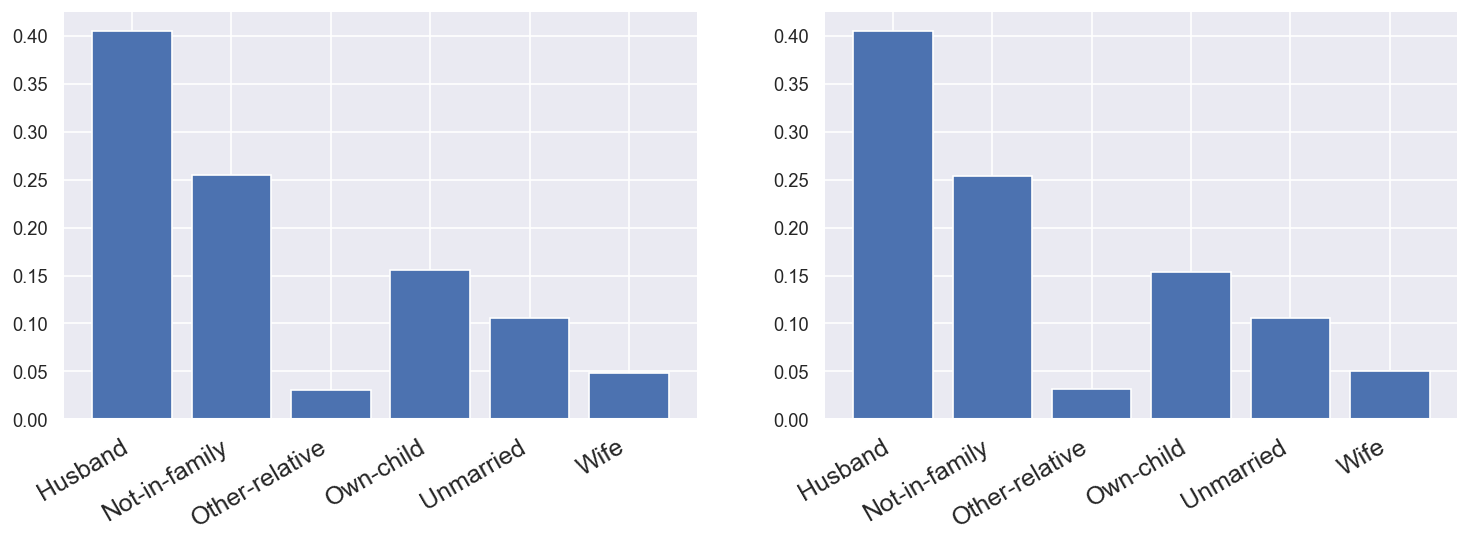

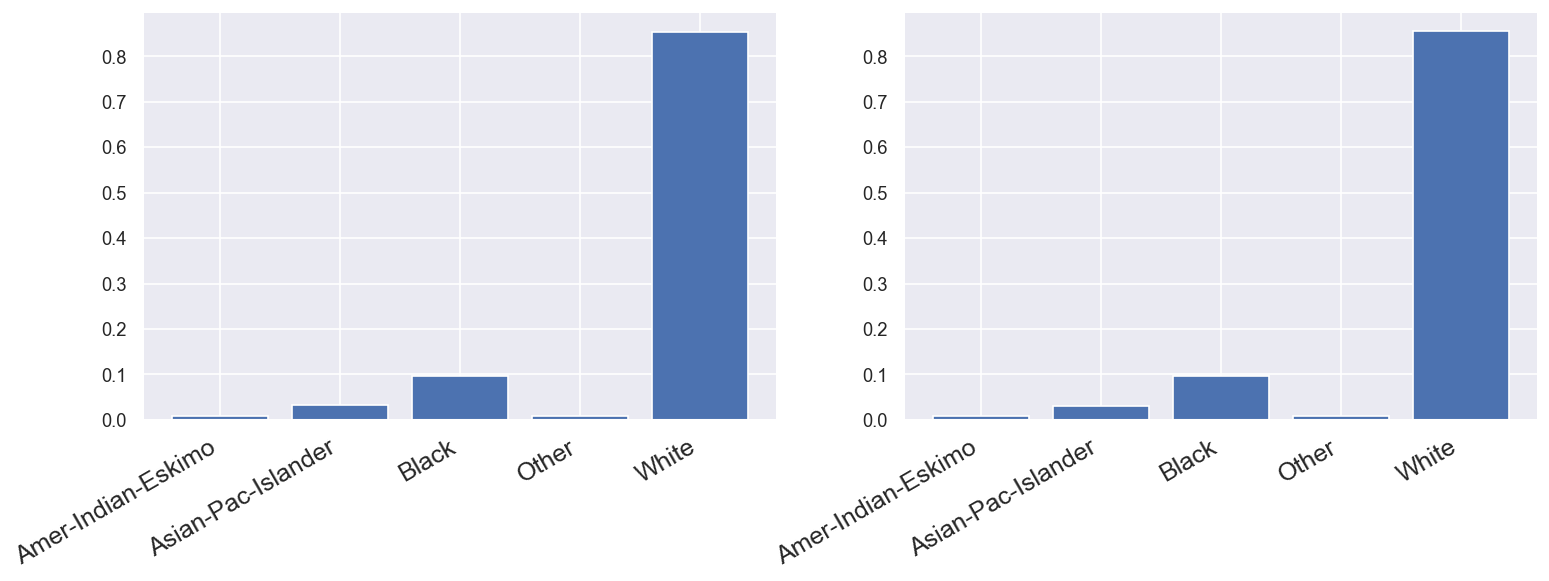

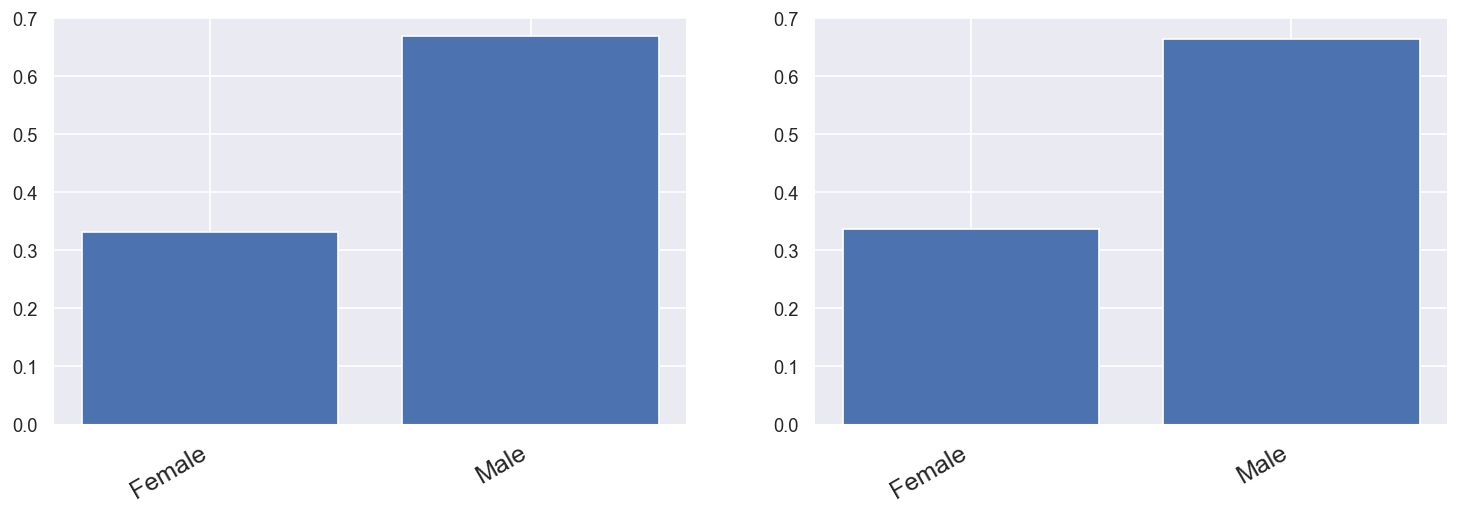

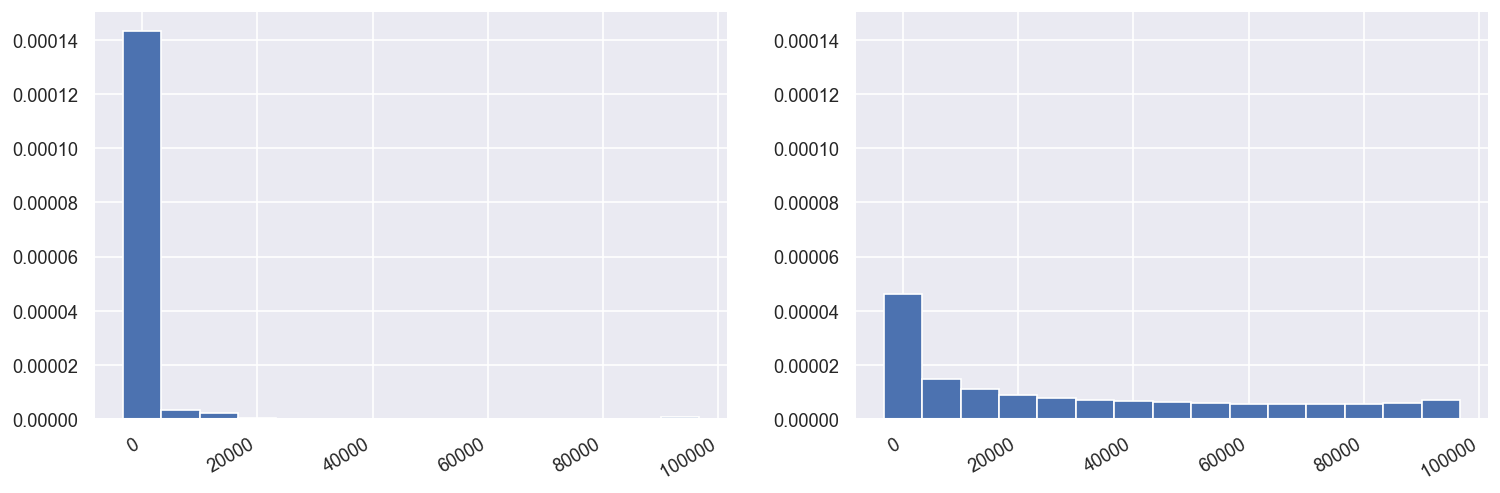

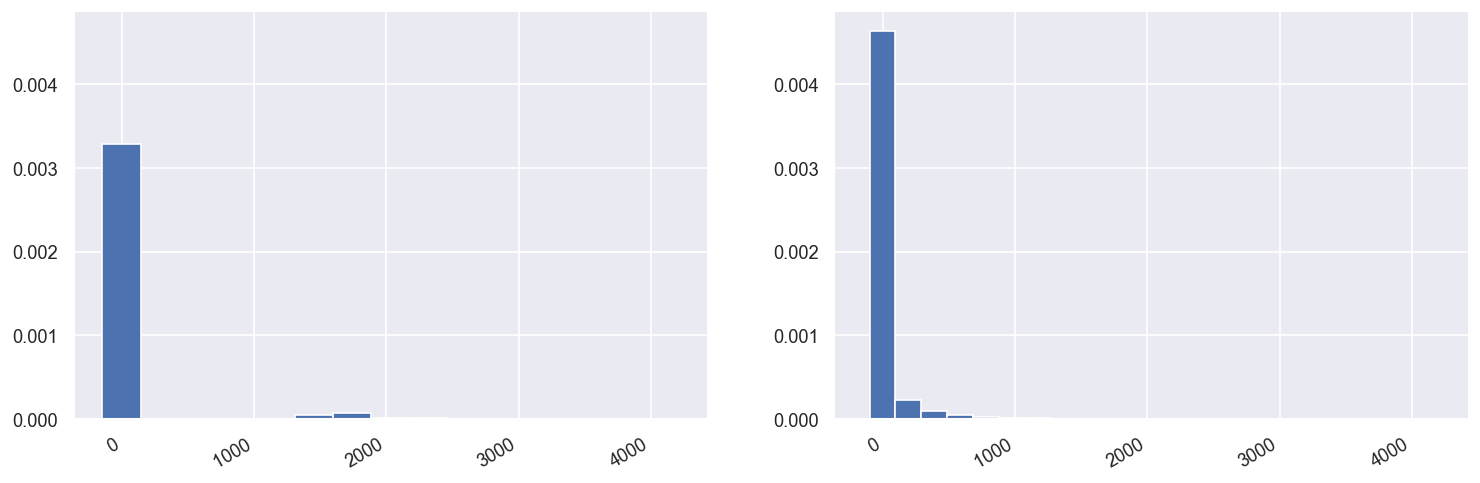

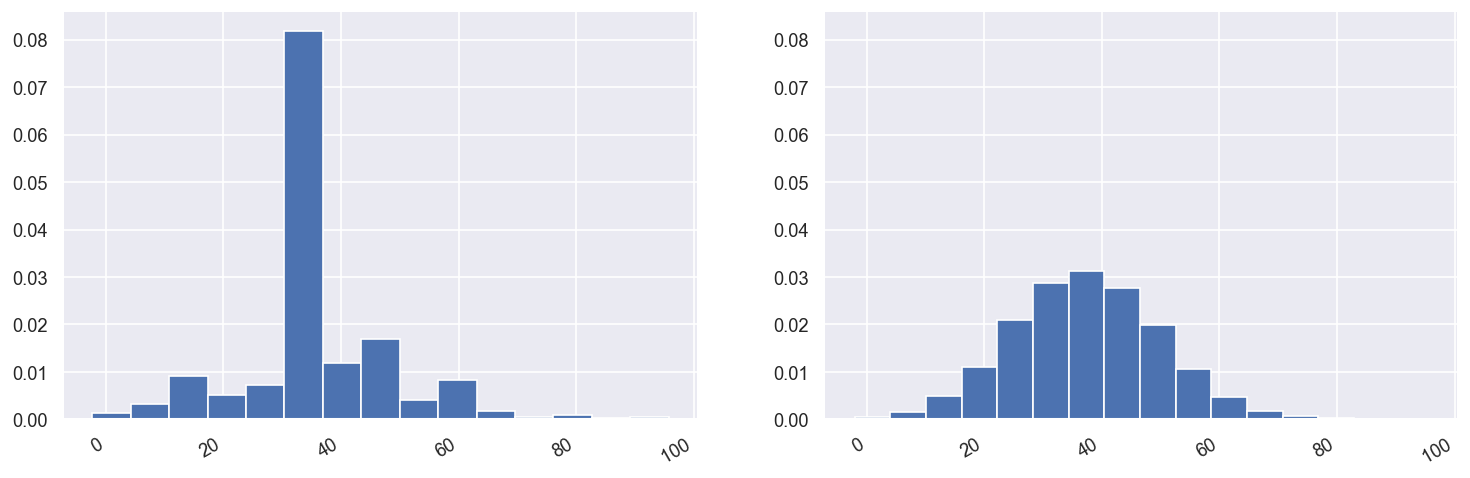

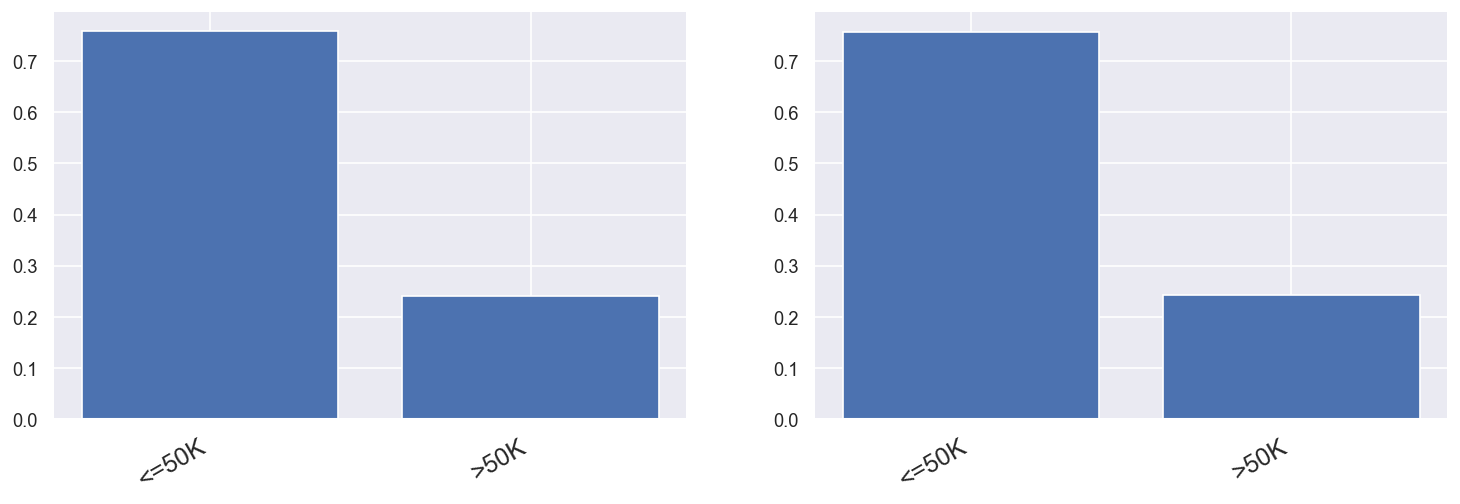

In [24]:
for attribute in synthetic_data.columns:
    inspector.compare_histograms(attribute)

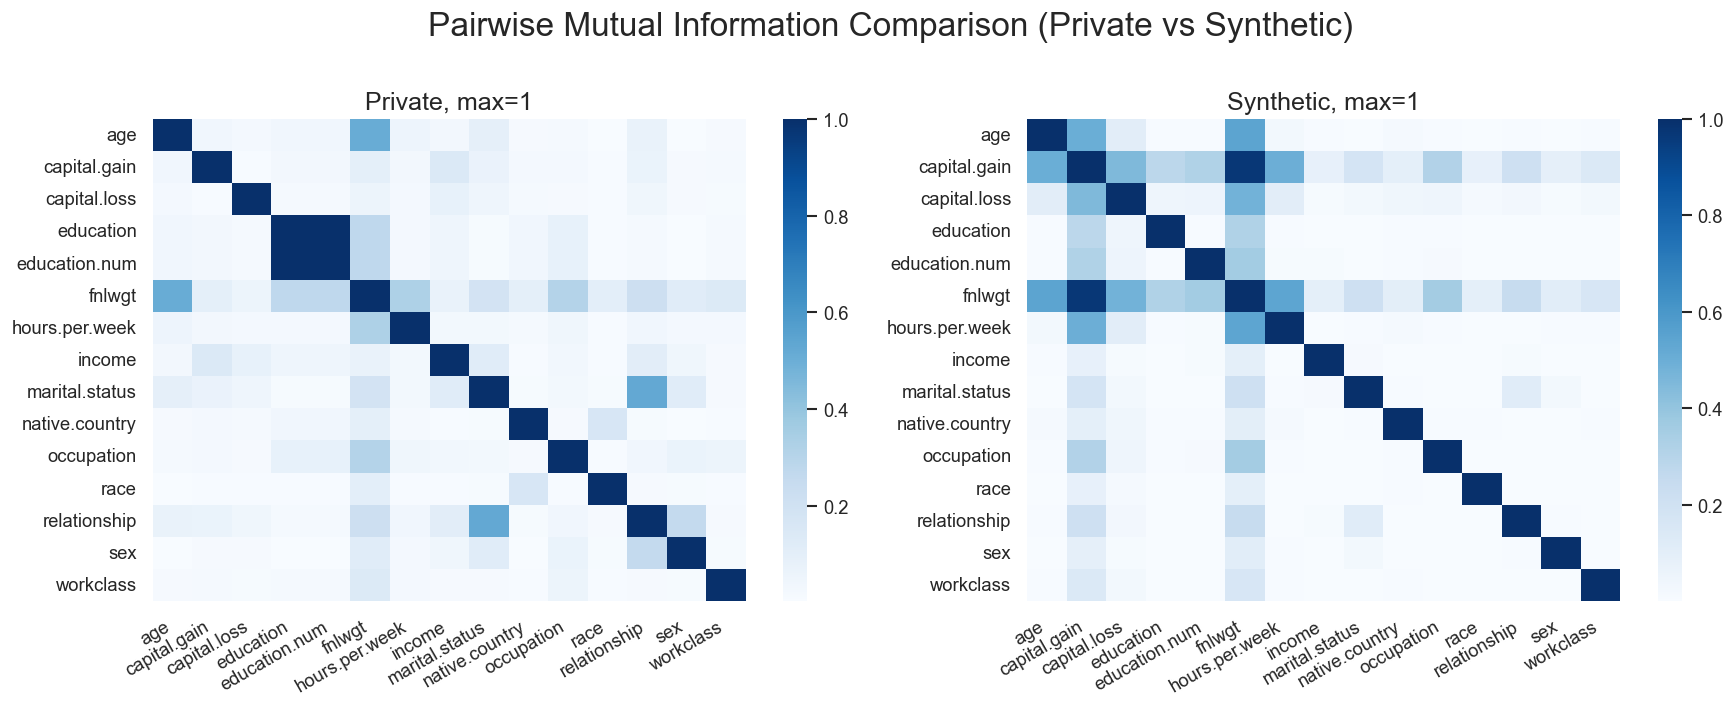

In [25]:
inspector.mutual_information_heatmap()

## Privacy Testing
Since there is no proposed way to measure privacy of synthetic data, we compare how far the real data is from the original data. These are methods used by SBA Research GmBH.

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

real_df = df.drop(['income'], axis=1)
syn_df = synthetic_data.drop(['income'], axis=1)

categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
for feature in categorical:
        le = LabelEncoder()
        real_df[feature] = le.fit_transform(real_df[feature])
        syn_df[feature] = le.fit_transform(syn_df[feature])

scaler = StandardScaler()

real_df = pd.DataFrame(scaler.fit_transform(real_df), columns = real_df.columns)
syn_df = pd.DataFrame(scaler.fit_transform(syn_df), columns = syn_df.columns)

# Use NearestNeighbors from scikit-learn
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(real_df)

# Find nearest neighbor in real for each synth row
distances, indices = nn.kneighbors(syn_df)

# `indices` gives the index in the real data for each synthetic row
# `distances` gives the Euclidean distance

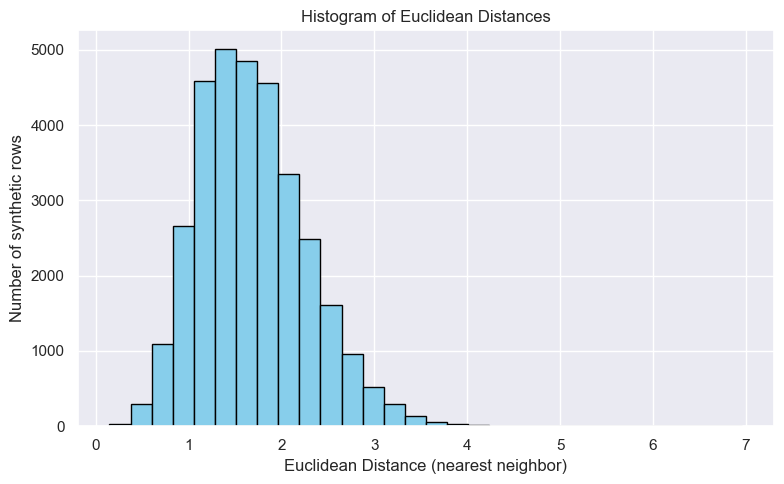

In [38]:
import matplotlib.pyplot as plt

# Flatten the distances array
distances_flat = distances.flatten()

plt.figure(figsize=(8,5))
plt.hist(distances_flat, bins=30, color='skyblue', edgecolor='black')

plt.title('Histogram of Euclidean Distances')
plt.xlabel('Euclidean Distance (nearest neighbor)')
plt.ylabel('Number of synthetic rows')

plt.tight_layout()
plt.show()


### Utility Testing -  ML
Perform ML (logistic regression) on the real and synthetic data set in order to compare utility. Look at the performance of both models.

In [13]:
# ************** Real data ************************
# Setting target and feature vector variables
X = df.drop(['income'], axis=1)
y = df['income']

X_syn = synthetic_data.drop(['income'], axis=1)
y_syn = synthetic_data['income']

In [14]:
# Split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [15]:
# Encode categorical variables
from sklearn import preprocessing

categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        
        X_test[feature] = le.transform(X_test[feature])
        
        X_syn[feature] = le.fit_transform(X_syn[feature])
        

In [16]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

X_syn = pd.DataFrame(scaler.fit_transform(X_syn), columns = X_syn.columns)

In [17]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr_real = LogisticRegression()
lr_real.fit(X_train, y_train)

lr_syn = LogisticRegression()
lr_syn.fit(X_syn, y_syn)

# Evaluate both on the same real test set
print("Model trained on REAL data:")
print(classification_report(y_test, lr_real.predict(X_test)))
print(accuracy_score(y_test, lr_real.predict(X_test)))

print("\nModel trained on SYNTHETIC data:")
print(classification_report(y_test, lr_syn.predict(X_test)))


Model trained on REAL data:
              precision    recall  f1-score   support

       <=50K       0.85      0.94      0.89      7429
        >50K       0.72      0.45      0.55      2340

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.81      0.83      0.81      9769

0.8258777766403931

Model trained on SYNTHETIC data:
              precision    recall  f1-score   support

       <=50K       0.77      1.00      0.87      7429
        >50K       0.90      0.08      0.14      2340

    accuracy                           0.78      9769
   macro avg       0.83      0.54      0.51      9769
weighted avg       0.80      0.78      0.70      9769



In [ ]:
# Cross validation - is the data internally consistent?
from sklearn.model_selection import cross_val_score

model = LogisticRegression ()
scores_real = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Real Data - CV Accuracy Scores:", scores_real)
print("Real Data - Mean Accuracy:", scores_real.mean())

# --- Cross-validation on SYNTHETIC data ---
scores_synth = cross_val_score(model, X_syn, y_syn, cv=5, scoring='accuracy')
print("\nSynthetic Data - CV Accuracy Scores:", scores_synth)
print("Synthetic Data - Mean Accuracy:", scores_synth.mean())

Real Data - CV Accuracy Scores: [0.82430358 0.82496161 0.82382624 0.81702501 0.8293111 ]
Real Data - Mean Accuracy: 0.8238855083286646

Synthetic Data - CV Accuracy Scores: [0.75909719 0.7590602  0.75767813 0.76013514 0.75476044]
Synthetic Data - Mean Accuracy: 0.7581462193737643


In [ ]:
# Using a different classifier
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc_real = RandomForestClassifier()
rfc_real.fit(X_train, y_train)

rfc_syn = RandomForestClassifier()
rfc_syn.fit(X_syn, y_syn)

# Evaluate both on the same real test set
print("Model trained on REAL data:")
print(classification_report(y_test, rfc_real.predict(X_test)))

print("\nModel trained on SYNTHETIC data:")
print(classification_report(y_test, rfc_syn.predict(X_test)))


Model trained on REAL data:
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      7429
        >50K       0.75      0.62      0.68      2340

    accuracy                           0.86      9769
   macro avg       0.82      0.78      0.79      9769
weighted avg       0.85      0.86      0.85      9769


Model trained on SYNTHETIC data:
              precision    recall  f1-score   support

       <=50K       0.79      0.99      0.88      7429
        >50K       0.82      0.15      0.26      2340

    accuracy                           0.79      9769
   macro avg       0.81      0.57      0.57      9769
weighted avg       0.80      0.79      0.73      9769



Accuracy reduces by 7 to 10%.